In [0]:
#used for visualisation
%pip install bokeh

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
file_path = '/FileStore/tables/clinicaltrial_2021_csv.gz'

In [0]:
import os
import pyspark.sql.functions as f
from pyspark.sql.functions import split,explode,from_unixtime,unix_timestamp,col,avg,window,sum
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.embed import file_html
from bokeh.resources import CDN

In [0]:
def file_exists(path):
    try:
        dbutils.fs.ls(path)
        return True
    except Exception as e:
        if 'java.io.FileNotFoundException' in str(e):
            return False
        else:
            raise

In [0]:
if file_exists(file_path) == True:
    fileroot = file_path.split("/")[3].split(".")[0]
    dbutils.fs.cp(file_path,"file:/tmp/")
else:
    print("File is not found in dbfs")

In [0]:
os.environ['fileroot'] = fileroot

In [0]:
%sh
gzip -d /tmp/ /tmp/$fileroot.gz

gzip: /tmp/ is a directory -- ignored


In [0]:
dbutils.fs.mv("file:/tmp/" + fileroot,"/FileStore/tables/")

Out[7]: True

In [0]:
if fileroot.endswith("_csv"):
    fileroot_new = fileroot.replace("_csv",".csv")
dbutils.fs.mv("/FileStore/tables/" + fileroot,"/FileStore/tables/" + fileroot_new)

Out[8]: True

Function for reading files

In [0]:
def read_file(file_path,header,delimiter):
    if header == True:
        return(spark.read.option("header",True).csv(file_path,sep=delimiter))
    else:
        return(spark.read.option("header",False).csv(file_path,sep=delimiter))

Reading files into data frames

In [0]:
file_path = "/FileStore/tables/"+fileroot_new
clinical_trail = read_file(file_path,True,"|")
mesh_df = read_file("/FileStore/tables/mesh.csv",True,",")
pharma_df = read_file("/FileStore/tables/pharma.csv",True,",")

Question 1

In [0]:
clinical_trail.select(clinical_trail.Id).distinct().count()

Out[11]: 387261

Question 2

In [0]:
clinical_trail.groupBy('Type').count().orderBy('count', ascending=False).show()

+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|301472|
|       Observational| 77540|
|Observational [Pa...|  8180|
|     Expanded Access|    69|
+--------------------+------+



Question 3

In [0]:
split_clinical_trail = clinical_trail.where(clinical_trail.Conditions!= ' ')\
                       .withColumn('splitConditions', split(clinical_trail.Conditions,","))
exploded_clinical_trail = split_clinical_trail.withColumn('Conditions', explode(split_clinical_trail.splitConditions))
exploded_clinical_trail.groupBy('Conditions').count().orderBy('count', ascending=False).show(5)

+-----------------+-----+
|       Conditions|count|
+-----------------+-----+
|        Carcinoma|13389|
|Diabetes Mellitus|11080|
|        Neoplasms| 9371|
| Breast Neoplasms| 8640|
|         Syndrome| 8032|
+-----------------+-----+
only showing top 5 rows



In [0]:
#to check the avreage of frequency of conditions
exploded_clinical_trail.groupBy('Conditions').count().orderBy('count', ascending=False).agg(avg(col("count"))).show()

+------------------+
|        avg(count)|
+------------------+
|173.22577829502472|
+------------------+



Question 4

In [0]:
mesh_df_trim = mesh_df.select(mesh_df.term,split(mesh_df.tree,'\.').getItem(0).alias('tree_code'))
exploded_clinical_trail.join(mesh_df_trim, exploded_clinical_trail.Conditions == mesh_df_trim.term)\
                        .groupBy("tree_code").count().orderBy('count', ascending=False).show(10)

+---------+------+
|tree_code| count|
+---------+------+
|      C04|143994|
|      C23|136079|
|      C01|106674|
|      C14| 94523|
|      C10| 92310|
|      C06| 85646|
|      C08| 70720|
|      C13| 42599|
|      C18| 41276|
|      C12| 40161|
+---------+------+
only showing top 10 rows



In [0]:
#to find out the unique conditions for the top most tree code C04
exploded_clinical_trail.join(mesh_df_trim.where(mesh_df_trim.tree_code == 'C04'), exploded_clinical_trail.Conditions == mesh_df_trim.term)\
                       .select(exploded_clinical_trail.Conditions).distinct().display()

Conditions
Adenocarcinoma of Lung
Stomach Neoplasms
Lymphomatoid Granulomatosis
Hereditary Breast and Ovarian Cancer Syndrome
Adrenal Gland Neoplasms
Bowens Disease
Pancreatic Neoplasms
Meningeal Neoplasms
Blast Crisis
Intestinal Neoplasms


Question 5

In [0]:
clinical_trail.join(pharma_df, clinical_trail.Sponsor == pharma_df.Parent_Company, "leftanti")\
               .groupby("Sponsor").count().orderBy('count', ascending=False).show(10)

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3218|
|M.D. Anderson Can...| 2414|
|Assistance Publiq...| 2369|
|         Mayo Clinic| 2300|
|Merck Sharp & Doh...| 2243|
|   Assiut University| 2154|
|Novartis Pharmace...| 2088|
|Massachusetts Gen...| 1971|
|    Cairo University| 1928|
|   Hoffmann-La Roche| 1828|
+--------------------+-----+
only showing top 10 rows



Question 6

In [0]:
clinical_trail_filter = clinical_trail.filter("Status == 'Completed'")\
                                      .withColumn('Completion_year',f.split(clinical_trail['Completion'], ' ').getItem(1))\
                                      .withColumn('Completion_month',f.split(clinical_trail['Completion'], ' ').getItem(0))\
                                      .filter("Completion_year == 2021").groupBy('Completion_month').count()
clinical_trail_sort = clinical_trail_filter.withColumn("mnth_number",from_unixtime(unix_timestamp(clinical_trail_filter["Completion_month"],'MMM'),'MM'))\
                                           .orderBy("mnth_number").select("Completion_month","count")
clinical_trail_sort.show()

+----------------+-----+
|Completion_month|count|
+----------------+-----+
|             Jan| 1131|
|             Feb|  934|
|             Mar| 1227|
|             Apr|  967|
|             May|  984|
|             Jun| 1094|
|             Jul|  819|
|             Aug|  700|
|             Sep|  528|
|             Oct|  187|
+----------------+-----+



Visualisation using Bokeh

In [0]:
Completion_month = list(clinical_trail_sort.select('Completion_month').toPandas()['Completion_month'])
counts = list(clinical_trail_sort.select('count').toPandas()['count'])

In [0]:
output_file("completion_line.html")
p = figure(x_range=Completion_month, height=450, title="Completion count based on month",
           toolbar_location=None, tools="")
p.line(Completion_month,counts,legend_label = 'Completed Frequency per month', width=2)
p.xgrid.grid_line_color = None
p.y_range.start = 0
html=file_html(p,CDN,"plot")
displayHTML(html)

<!DOCTYPE html>
 
 
 
 
 
 plot

Visualisation using Matplotlib

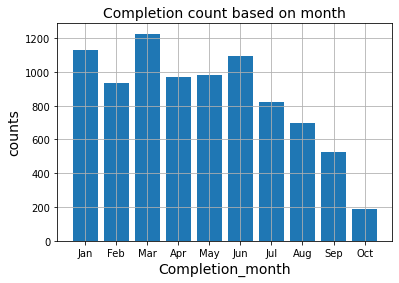

In [0]:
plt.bar(Completion_month, counts)
plt.title('Completion count based on month', fontsize=14)
plt.xlabel('Completion_month', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.grid(True)
plt.show()

Visualisation using Databricks

In [0]:
clinical_trail_sort.display()

Completion_month,count
Jan,1131
Feb,934
Mar,1227
Apr,967
May,984
Jun,1094
Jul,819
Aug,700
Sep,528
Oct,187


Further Analysis 1

In [0]:
clinical_percent = clinical_trail.groupBy('Status').count()\
                                 .withColumn('percent', f.col('count')*100.00/f.sum('count').over(Window.partitionBy()))
clinical_percent.orderBy('percent', ascending=False)\
                .select(clinical_percent.Status,f.col('count'),f.round(clinical_percent.percent,3).alias('percentage of clinical trials')).show()

+--------------------+------+-----------------------------+
|              Status| count|percentage of clinical trials|
+--------------------+------+-----------------------------+
|           Completed|209749|                       54.162|
|          Recruiting| 60950|                       15.739|
|      Unknown status| 44608|                       11.519|
|          Terminated| 22285|                        5.755|
|Active, not recru...| 17848|                        4.609|
|  Not yet recruiting| 16499|                         4.26|
|           Withdrawn|  9973|                        2.575|
|Enrolling by invi...|  3682|                        0.951|
|           Suspended|  1598|                        0.413|
| No longer available|    39|                         0.01|
|Approved for mark...|    24|                        0.006|
|           Available|     5|                        0.001|
|Temporarily not a...|     1|                          0.0|
+--------------------+------+-----------

Further Analysis 2

In [0]:
clinical_trail_filter = clinical_trail.filter("Status == 'Completed'")\
                                      .withColumn('Completion_year',f.split(clinical_trail.Completion, ' ').getItem(1))\
                                      .withColumn('Completion_month',f.split(clinical_trail.Completion, ' ').getItem(0))\
                                      .withColumn('Start_year',f.split(clinical_trail.Start, ' ').getItem(1))\
                                      .withColumn('Start_month',f.split(clinical_trail.Start, ' ').getItem(0))
clinical_trail_filter = clinical_trail_filter.withColumn("comp_mnth_number",from_unixtime(unix_timestamp(clinical_trail_filter.Completion_month,'MMM'),'MM'))\
                                             .withColumn("start_mnth_number",from_unixtime(unix_timestamp(clinical_trail_filter.Start_month,'MMM'),'MM'))
clinical_trail_filter = clinical_trail_filter.withColumn('Number_of_Months_for_Completion',((clinical_trail_filter.Completion_year - clinical_trail_filter.Start_year)*12-                                                        clinical_trail_filter.start_mnth_number+clinical_trail_filter.comp_mnth_number).cast('int'))
clinical_trail_filter.select(clinical_trail_filter.Start_year,clinical_trail_filter.start_mnth_number,clinical_trail_filter.Completion_year,clinical_trail_filter.comp_mnth_number,clinical_trail_filter.Number_of_Months_for_Completion).display()


Start_year,start_mnth_number,Completion_year,comp_mnth_number,Number_of_Months_for_Completion
2016,07,2020,07,48
2017,03,2018,01,10
2012,01,2014,12,35
2016,04,2018,01,21
2016,03,2017,07,16
2017,08,2021,01,41
2016,04,2016,10,6
2015,05,2015,12,7
2015,06,2016,03,9
2016,04,2019,05,37


Further Analysis 3

In [0]:
clinical_trail_filter.groupby('Type').agg(avg(col("Number_of_Months_for_Completion")).cast('float').alias('Avg time for completion')).show()

+--------------------+-----------------------+
|                Type|Avg time for completion|
+--------------------+-----------------------+
|Observational [Pa...|              31.887775|
|      Interventional|              30.046839|
|       Observational|               35.94214|
+--------------------+-----------------------+

